In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
import pickle
import math
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy.video.io.ImageSequenceClip
%matplotlib inline


In [3]:
#Camera Calibration
def calibrate_Camera(camera_cal_location = 'camera_cal/calibration*.jpg'):
    nx = 9
    ny = 6

    1#for img in os.listdir("camera_cal/"):
    objp = np.zeros((9*6, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img', img)
            cv2.waitKey(500)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return mtx,dist

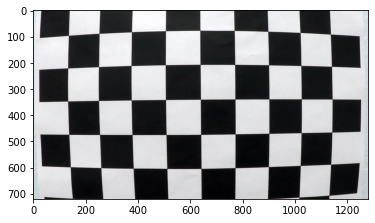

In [4]:
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
plt.imshow(img)

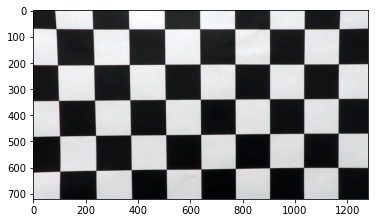

In [5]:

# Do camera calibration given object points and image points

mtx,dist = calibrate_Camera('camera_cal/calibration*.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(dst)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/camera_dist_pickle.p", "wb" ))


In [6]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def s_channel(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    schannel = hls[:,:,2]
    return schannel
def l_channel(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return hls[:,:,1]
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)    
    return histogram

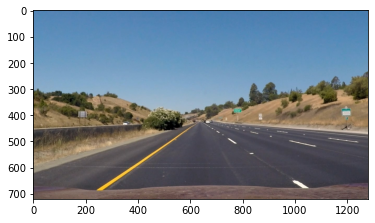

In [8]:
dist_pickl = pickle.load( open( "camera_cal/camera_dist_pickle.p", "rb" ) )
mtx = dist_pickl["mtx"]
dist = dist_pickl["dist"]

output_dir = "output_images/"
dir_test = "test_images"
Image_org = []
weighted = []
warped_In = []
warped_Ext = []
warped_out = []
canny_warp = []
Undistort = []
for img in os.listdir("test_images/"):
    kernel_size = 9
    image = mpimg.imread(str(os.path.join(dir_test,img)))

    img_size = (image.shape[1], image.shape[0])
    imshape = (image.shape[0], image.shape[1])

    Image_org.append(image)
    
    
    #Undistort Image
    
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    Undistort.append(undist)
    
    ####Get Warp Matrix transformation
    
    vertices = np.array([[(imshape[1]*1.17/7.5,imshape[0]),(imshape[1]*0.462, imshape[0]*0.63), (imshape[1]*0.541, imshape[0]*0.63), (0.867*imshape[1],imshape[0])]], dtype=np.int32)
    dst = [[imshape[1]*1/6,0],[imshape[1]*4.7/6,0],[imshape[1]/6,imshape[0]],[imshape[1]*4.7/6,imshape[0]]]
    dst = np.float32(dst)
    src = np.float32([vertices[0][1],vertices[0][2],vertices[0][0],vertices[0][3]])
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    


    
    #Warp output purpose
    lines = undist
    cv2.polylines(lines, vertices, True, (255,0,0), thickness=2)  
    weighted.append(lines)
    warped = cv2.warpPerspective(lines, M, img_size, flags=cv2.INTER_LINEAR)
    warped_out.append(warped)
    
    
    #Image Processing for line detection
       
    warped_int = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    warped_In.append(warped_int)
    gray = grayscale(warped_int)
    gaus_blur = gaussian_blur(gray,5)
    

    

    
    schannel = s_channel(warped_int)
    # Threshold color channel
    s_thresh_min = 120
    s_thresh_max = 255
    s_binary = np.zeros_like(schannel)
    s_binary[(schannel >= s_thresh_min) & (schannel <= s_thresh_max)] = 1
    
    lchannel = l_channel(warped_int)
    l_thresh_min = 110
    l_thresh_max = 255
    l_binary = np.zeros_like(schannel)
    l_binary[(lchannel >= l_thresh_min) & (lchannel <= l_thresh_max)] = 1
    
    
    combined_binary = np.zeros_like(schannel)
    combined_binary[(s_binary == 1) & (l_binary == 1)] = 1
    
    
        
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    thresh_min = 30
    thresh_max = 255
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    combined = np.zeros_like(schannel)
    combined[(sxbinary == 1 ) | (combined_binary == 1)] = 1
    

    gray_check = np.zeros_like(gray)
    low_gray =50
    high_gray = 255
    gray_check[(gray >= low_gray) & (gray <= high_gray)] = 1
    
    final = np.zeros_like(gray)
    final[(combined == 1) & (gray_check == 1)] = 1
    combined_scaled = np.uint8(255*final)


    canny_comb = combined_scaled
    canny_warp.append(canny_comb)

    cv2.imwrite(os.path.join(output_dir ,  'output_' + str(img)),lines)
    cv2.imwrite(os.path.join(output_dir ,  'warped_' + str(img)),warped)
    
plt.imshow(Image_org[0])

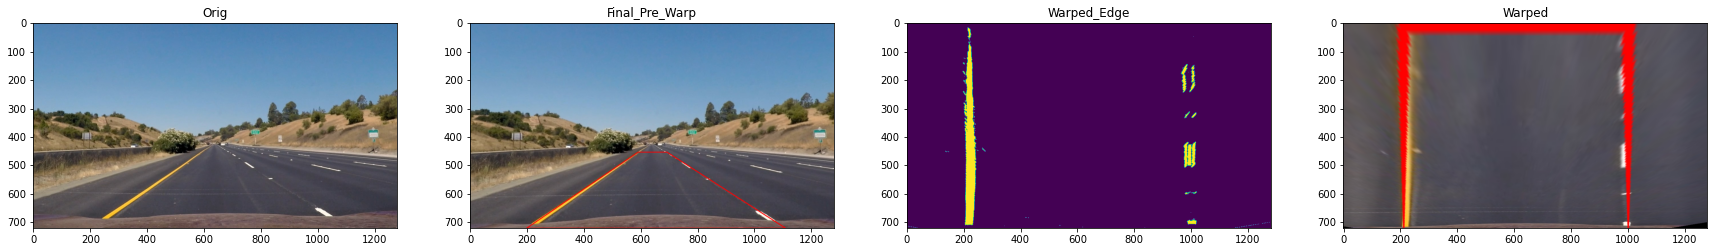

In [9]:
m = int(0)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,10))
ax1.set_title('Orig')
ax1.imshow(Image_org[m])

ax2.set_title('Final_Pre_Warp')
ax2.imshow(weighted[m])

ax4.set_title('Warped')
ax4.imshow(warped_out[m])

ax3.set_title('Warped_Edge')
ax3.imshow(canny_warp[m])

5482.092092173882 9874.236841880214


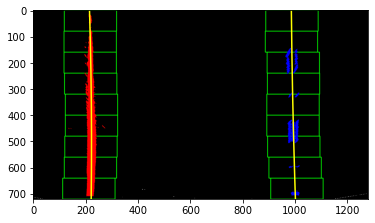

In [10]:
### Trial for processing each image and in order to calibrate the thresholds
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###

        
        #print(np.array(nonzero).shape)
        good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]

        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))
        if len(good_left_inds) > minpix :
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        
         # Remove this when you add your function

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fit = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fit = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fit = 1*ploty**2 + 1*ploty
        right_fit = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fit, ploty, color='yellow')
    plt.plot(right_fit, ploty, color='yellow')
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = 0  ## Implement the calculation of the left line here
    temp = 1 + (2*left_fit[0]*y_eval + left_fit[1])**2
    temp = math.pow(temp,1.5)
    temp = temp/abs(2*left_fit[0])
    left_curverad = temp
    right_curverad = 0  ## Implement the calculation of the right line here
    temp = 1 + (2*right_fit[0]*y_eval + right_fit[1])**2
    temp = math.pow(temp,1.5)
    temp = temp/abs(2*right_fit[0])
    right_curverad = temp
    

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    ##### TO-DO: Fit new polynomials to x,y in world space #####
    ##### Utilize `ym_per_pix` & `xm_per_pix` here #####
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fit*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fit*xm_per_pix, 2)
    
    left_curverad = 0  ## Implement the calculation of the left line here
    right_curverad = 0  ## Implement the calculation of the right line here
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
    return left_curverad, right_curverad,out_img


L_r,R_r,out_img = fit_polynomial(canny_warp[m])
plt.imshow(out_img)
print(L_r,R_r)

In [12]:
#### Image Processing Pipeline
def process_image(image, mtx,dist,M):
    
    # Undistort the image based on Camera Calibration
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    
    #Image Processing for line detection
    # 1. Un warp the image 
    warped_int = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    
    # 2.aGuassian Blur the grayed image
    gray = grayscale(warped_int)
    #gaus_blur = gaussian_blur(gray,5)

    # 2.b Selecting S channel of the image and applying threshold
    schannel = s_channel(warped_int)
    # Threshold color channel
    s_thresh_min = 120
    s_thresh_max = 255
    s_binary = np.zeros_like(schannel)
    s_binary[(schannel >= s_thresh_min) & (schannel <= s_thresh_max)] = 1
    
    # 2.c Selecting l channel of the image and applying threshold
    lchannel = l_channel(warped_int)
    l_thresh_min = 100
    l_thresh_max = 255
    l_binary = np.zeros_like(schannel)
    l_binary[(lchannel >= l_thresh_min) & (lchannel <= l_thresh_max)] = 1
    
    # 2.d Applying combined thresholding for S and L channel
    combined_binary = np.zeros_like(schannel)
    combined_binary[(s_binary == 1) & (l_binary == 1)] = 1
    
    
    # 2.e Taking derivative of the image along x axis in order to obtain vertical lines and applying thresholds   
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    thresh_min = 30
    thresh_max = 255
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # 2.f Combined S,L , Gray and Derivative thresholding
    combined = np.zeros_like(schannel)
    combined[(sxbinary == 1 ) | (combined_binary == 1)] = 1
    

    
    # 2.g Final Filter to have a better chance of picking the lanes and not the surrounding
    gray_check = np.zeros_like(gray)
    low_gray =50
    high_gray = 255
    gray_check[(gray >= low_gray) & (gray <= high_gray)] = 1
    
    # 2.h Final processed Image for detecting lanes
    final = np.zeros_like(gray)
    final[(combined == 1) & (gray_check == 1)] = 1
    combined_scaled = np.uint8(255*final)

    canny_comb = combined_scaled
    
    # Returning the processed image as well as the warped color image in order to draw the detected lane
    return canny_comb,warped_int,undist

    

In [13]:
# Obtaining images from the video and processing each image and storing them for lane detection
cam = cv2.VideoCapture("project_video.mp4") 
duration  = VideoFileClip("project_video.mp4").duration

currentframe = 0
Canny_comb = []
Warped_Im = []
Undist = []
Image_orig = []
while(True): 
      
    # reading from frame 
    ret,frame = cam.read() 
  
    if ret: 
        # if video is still left continue creating images 
        name = './data/frame' + str(currentframe) + '.jpg'
  
        # writing the extracted images 
        Image_orig.append(frame)  # Storing the original video images
        Im1,Im2,Im3 = process_image(frame,mtx,dist,M)
        Canny_comb.append(Im1) # Processed Image for Lane Detection
        Warped_Im.append(Im2) # Storing the Warped Image 
        Undist.append(Im3) # Storing the Undistorted Image
        # increasing counter so that it will 
        # show how many frames are created 
        currentframe += 1
    else: 
        break
  
# Release all space and windows once done 
cam.release() 
cv2.destroyAllWindows() 
width,height,_ = Image_orig[0].shape
fps = int(currentframe/duration) # calculating the fps in order to write the output video

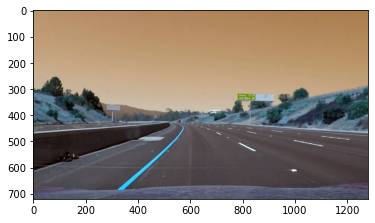

In [19]:
plt.imshow(Image_orig[10])


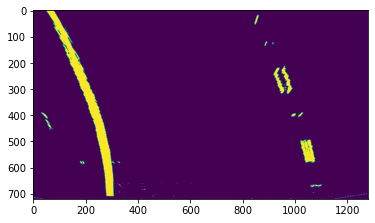

In [15]:
plt.imshow(Canny_comb[10])


In [27]:
margin = 100
n= 10
nwindows = 9
minpix = 50
ym_per_pix = 30/720
xm_per_pix = 3/750
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = []   
        self.recent_fits = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = []
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = [] 
        #distance in meters of vehicle center from the line
        self.line_base_pos = [] 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = []  
        #y values for detected line pixels
        self.ally = []  
    def show(self):
        print(self.current_fit)
        print(self.radius_of_curvature)
    def find_base(self,binary_warped,lane): # Finding x base for a lane
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        if lane == 'L' :
            return leftx_base
        elif lane == 'R' :
            return rightx_base
    def measure_curvature_pixels(self,binary_warped):  # Measuring Radius of curvature for a given lane

        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        
        x = self.current_fit[0]*ploty**2 + self.current_fit[1]*ploty + self.current_fit[2]       
        # Fit a second order polynomial to pixel positions in each fake lane line
        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(ploty*ym_per_pix, x*xm_per_pix, 2)
        y_eval = np.max(ploty)
        curverad = 0  ## Implement the calculation of the left line here
        temp = 1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2
        temp = math.pow(temp,1.5)
        self.radius_of_curvature = temp/abs(2*self.current_fit[0])
        
    def search_around_poly(self,binary_warped): # Search around the previous polynomial fir if valid
        # Grab activated pixels 
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### TO-DO: Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        lane_inds = ((nonzerox > (self.current_fit[0]*(nonzeroy**2) + self.current_fit[1]*nonzeroy + 
                        self.current_fit[2] - margin)) & (nonzerox < (self.current_fit[0]*(nonzeroy**2) + 
                        self.current_fit[1]*nonzeroy + self.current_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds] 
        self.allx.extend(x)
        self.allx.extend(y)
        return x,y
        
        
    def find_lane_pixels(self,binary_warped,warped,x_base):    # Find the Lane pixels through Sliding window approach
        # Take a histogram of the bottom half of the image

        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))


        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        x_current = x_base

        # Create empty lists to receive left and right lane pixel indices
        lane_inds = []
        

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            ### TO-DO: Find the four below boundaries of the window ###
            win_x_low = x_current - margin  # Update this
            win_x_high = x_current + margin  # Update this
            good_inds = ((nonzerox >= win_x_low) & (nonzerox < win_x_high) & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
            
            # Append these indices to the lists
            lane_inds.append(good_inds)


            if len(good_inds) > minpix:
                x_current = int(np.mean(nonzerox[good_inds]))
        
        try:
            lane_inds = np.concatenate(lane_inds)
        except ValueError:
            pass

        # Extract line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds] 
        self.allx.extend(x)
        self.allx.extend(y)
        return x,y
        
    def fit_polynomial(self,x,y,binary_warped):  # Fit a polynomial based on identified x and y pixels
        # Find our lane pixels first
        self.detected = False
        current_fit = np.polyfit(y, x, 2)
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        try:
            fitx = current_fit[0]*ploty**2 + current_fit[1]*ploty + current_fit[2]
            self.detected = True
            self.diffs = self.current_fit - current_fit
            self.current_fit = current_fit    
            return True

        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            self.current_fit = 1*ploty**2 + 1*ploty
            self.detected = False
            return False
            





In [31]:
Left_Lane = Line()
Right_Lane = Line()
Resulting = []
rad_thd = 300
dist_thd_max = 1000
dist_thd_min = 700
rad_min = 3000

In [32]:

for i in range(0,len(Canny_comb)):
    
    ######### Find the approproriate Left Lane and its paremeters
    # Checking if there is any valid polynomial fit in the previous iteration and if not, then detect base pixel and use sliding 
    # approach to find lane pixels. if there is a valid polynomial fit in the previous iteration, then search around the previous 
    # polynomial fit
    # Fit the polynomial based on detected pixels
    if Left_Lane.detected == False :  
        x_base = Left_Lane.find_base(Canny_comb[i],'L')      ######Find base if there is no previous iteration poly  
        x,y = Left_Lane.find_lane_pixels(Canny_comb[i],Warped_Im[i],x_base)##Sliding window method
    else:
        x,y = Left_Lane.search_around_poly(Canny_comb[i]) # Search around previous poly
    
   
    L_d = Left_Lane.fit_polynomial(x,y,Canny_comb[i])
   
    if Right_Lane.detected == False :
        x_base = Right_Lane.find_base(Canny_comb[i],'R')        ######Find base if there is no previous iteration poly
        x,y = Right_Lane.find_lane_pixels(Canny_comb[i],Warped_Im[i],x_base) ##Sliding window method
    else:
        x,y = Right_Lane.search_around_poly(Canny_comb[i]) # Search around previous poly
        
        
    
    R_d = Right_Lane.fit_polynomial(x,y,Canny_comb[i])
    
    #Find the y pixels
    ploty = np.linspace(0, Canny_comb[i].shape[0]-1, Canny_comb[i].shape[0])
    
    # Extracting left and right x points based on polynomial fit
    left_cur = Left_Lane.current_fit[0]*ploty**2 + Left_Lane.current_fit[1]*ploty + Left_Lane.current_fit[2]
    right_cur = Right_Lane.current_fit[0]*ploty**2 + Right_Lane.current_fit[1]*ploty + Right_Lane.current_fit[2]
    
        
       
    # Measure Radius of Curvature based on current polynomial fit
    Left_Lane.measure_curvature_pixels(Canny_comb[i])
    Right_Lane.measure_curvature_pixels(Canny_comb[i])
    
    # Checking the validity of the polynomial fit based on Radius of curvature, distance between left and right lane at extreme points
    #to check for equi distance
    if ( (L_d and R_d) and 
        ((Left_Lane.radius_of_curvature > rad_min and Left_Lane.radius_of_curvature > rad_min) or (np.abs(Left_Lane.radius_of_curvature - Right_Lane.radius_of_curvature) < rad_thd)) and 
        np.abs( (left_cur[len(ploty) -1]) - (right_cur[len(ploty)- 1]) ) < dist_thd_max  and  
        np.abs( (left_cur[len(ploty) -1]) - (right_cur[len(ploty)- 1]) ) > dist_thd_min and
        np.abs( (left_cur[0]) - (right_cur[0]) ) < dist_thd_max  and  
        np.abs( (left_cur[0]) - (right_cur[0]) ) > dist_thd_min ):
        Left_Lane.detected = True
        Right_Lane.detected = True
    else :
        Left_Lane.detected = False
        Right_Lane.detected = False
    
    ## Store the X fits, polynomial coeffecients for the fit if the detected lanes are valid
    if Left_Lane.detected :
        if (len(Left_Lane.recent_xfitted) <= n ):
            Left_Lane.recent_xfitted.append(left_cur)
            Left_Lane.recent_fits.append([Left_Lane.current_fit])
        else :
            Left_Lane.recent_xfitted = Left_Lane.recent_xfitted[1:]
            Left_Lane.recent_xfitted.append(left_cur)
            Left_Lane.recent_fits = Left_Lane.recent_fits[1:]
            Left_Lane.recent_fits.append([Left_Lane.current_fit])
        
        Left_Lane.best_fit = np.average(Left_Lane.recent_fits,axis = 0)
        Left_Lane.bestx = np.average(Left_Lane.recent_xfitted)
      ######### Find the approproriate Right Lane and its paremeters    
    
    
    if Right_Lane.detected :
        if (len(Right_Lane.recent_xfitted) <= n ):
            Right_Lane.recent_xfitted.append(right_cur)
            Right_Lane.recent_fits.append([Right_Lane.current_fit])
        else :
            Right_Lane.recent_xfitted = Right_Lane.recent_xfitted[1:]
            Right_Lane.recent_xfitted.append(right_cur)
            Right_Lane.recent_fits = Right_Lane.recent_fits[1:]
            Right_Lane.recent_fits.append([Right_Lane.current_fit])
        
        Right_Lane.best_fit = np.average(Right_Lane.recent_fits,axis = 0)
        Right_Lane.bestx = np.average(Right_Lane.recent_xfitted)

    ############ Post-Processing to visualize
    # Recast the x and y points into usable format for cv2.fillPoly()
    

    
    left_xfit = Left_Lane.best_fit[0][0]*ploty**2 + Left_Lane.best_fit[0][1]*ploty + Left_Lane.best_fit[0][2]
    right_xfit = Right_Lane.best_fit[0][0]*ploty**2 + Right_Lane.best_fit[0][1]*ploty + Right_Lane.best_fit[0][2]  
    
    
    pts_left = np.array([np.transpose(np.vstack([left_xfit, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_xfit, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    warp_zero = np.zeros_like(Canny_comb[i]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (Image_orig[i].shape[1], Image_orig[i].shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(Undist[i], 1, newwarp, 0.2, 0)

    Resulting.append(result)
    
    
 

In [22]:
print(Right_Lane.radius_of_curvature,Left_Lane.radius_of_curvature)

5483.005105354192 12399.830697569878


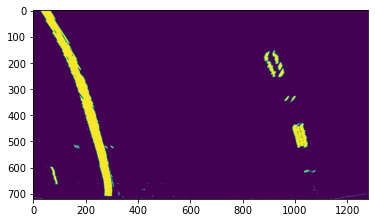

In [23]:
plt.imshow(Canny_comb[20])

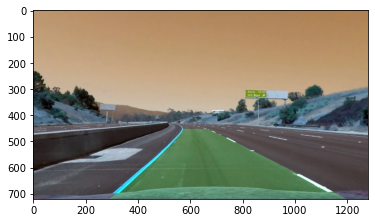

In [24]:
plt.imshow(Resulting[18])

In [33]:

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(Resulting, fps=fps)
clip.write_videofile('my_video.mp4')

Moviepy - Building video my_video.mp4.
Moviepy - Writing video my_video.mp4



Moviepy - Done !
Moviepy - video ready my_video.mp4


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('my_video.mp4'))

In [37]:
 cam = cv2.VideoCapture("harder_challenge_video.mp4") 
duration  = VideoFileClip("harder_challenge_video.mp4").duration

currentframe = 0
Canny_comb = []
Warped_Im = []
Undist = []
Image_orig = []
while(True): 
      
    # reading from frame 
    ret,frame = cam.read() 
  
    if ret: 
        # if video is still left continue creating images 
        name = './data/frame' + str(currentframe) + '.jpg'
  
        # writing the extracted images 
        Image_orig.append(frame)  # Storing the original video images
        Im1,Im2,Im3 = process_image(frame,mtx,dist,M)
        Canny_comb.append(Im1) # Processed Image for Lane Detection
        Warped_Im.append(Im2) # Storing the Warped Image 
        Undist.append(Im3) # Storing the Undistorted Image
        # increasing counter so that it will 
        # show how many frames are created 
        currentframe += 1
    else: 
        break
  
# Release all space and windows once done 
cam.release() 
cv2.destroyAllWindows() 
width,height,_ = Image_orig[0].shape
fps = int(currentframe/duration) # calculating the fps in order to write the output video

In [38]:
Left_Lane = Line()
Right_Lane = Line()
Resulting = []
rad_thd = 30000
dist_thd_max = 100000
dist_thd_min = 70
rad_min = 3000

In [43]:
for i in range(0,len(Canny_comb)):
    
    ######### Find the approproriate Left Lane and its paremeters
    # Checking if there is any valid polynomial fit in the previous iteration and if not, then detect base pixel and use sliding 
    # approach to find lane pixels. if there is a valid polynomial fit in the previous iteration, then search around the previous 
    # polynomial fit
    # Fit the polynomial based on detected pixels
    if Left_Lane.detected == False :  
        x_base = Left_Lane.find_base(Canny_comb[i],'L')      ######Find base if there is no previous iteration poly  
        x,y = Left_Lane.find_lane_pixels(Canny_comb[i],Warped_Im[i],x_base)##Sliding window method
    else:
        x,y = Left_Lane.search_around_poly(Canny_comb[i]) # Search around previous poly
    
   
    L_d = Left_Lane.fit_polynomial(x,y,Canny_comb[i])
   
    if Right_Lane.detected == False :
        x_base = Right_Lane.find_base(Canny_comb[i],'R')        ######Find base if there is no previous iteration poly
        x,y = Right_Lane.find_lane_pixels(Canny_comb[i],Warped_Im[i],x_base) ##Sliding window method
    else:
        x,y = Right_Lane.search_around_poly(Canny_comb[i]) # Search around previous poly
        
        
    
    R_d = Right_Lane.fit_polynomial(x,y,Canny_comb[i])
    
    #Find the y pixels
    ploty = np.linspace(0, Canny_comb[i].shape[0]-1, Canny_comb[i].shape[0])
    
    # Extracting left and right x points based on polynomial fit
    left_cur = Left_Lane.current_fit[0]*ploty**2 + Left_Lane.current_fit[1]*ploty + Left_Lane.current_fit[2]
    right_cur = Right_Lane.current_fit[0]*ploty**2 + Right_Lane.current_fit[1]*ploty + Right_Lane.current_fit[2]
    
        
       
    # Measure Radius of Curvature based on current polynomial fit
    Left_Lane.measure_curvature_pixels(Canny_comb[i])
    Right_Lane.measure_curvature_pixels(Canny_comb[i])
    
    # Checking the validity of the polynomial fit based on Radius of curvature, distance between left and right lane at extreme points
    #to check for equi distance
    if ( (L_d and R_d) and 
        ((Left_Lane.radius_of_curvature > rad_min and Left_Lane.radius_of_curvature > rad_min) or (np.abs(Left_Lane.radius_of_curvature - Right_Lane.radius_of_curvature) < rad_thd)) and 
        np.abs( (left_cur[len(ploty) -1]) - (right_cur[len(ploty)- 1]) ) < dist_thd_max  and  
        np.abs( (left_cur[len(ploty) -1]) - (right_cur[len(ploty)- 1]) ) > dist_thd_min and
        np.abs( (left_cur[0]) - (right_cur[0]) ) < dist_thd_max  and  
        np.abs( (left_cur[0]) - (right_cur[0]) ) > dist_thd_min ):
        Left_Lane.detected = True
        Right_Lane.detected = True
    else :
        Left_Lane.detected = False
        Right_Lane.detected = False
    
    ## Store the X fits, polynomial coeffecients for the fit if the detected lanes are valid
    if Left_Lane.detected :
        if (len(Left_Lane.recent_xfitted) <= n ):
            Left_Lane.recent_xfitted.append(left_cur)
            Left_Lane.recent_fits.append([Left_Lane.current_fit])
        else :
            Left_Lane.recent_xfitted = Left_Lane.recent_xfitted[1:]
            Left_Lane.recent_xfitted.append(left_cur)
            Left_Lane.recent_fits = Left_Lane.recent_fits[1:]
            Left_Lane.recent_fits.append([Left_Lane.current_fit])
        
        Left_Lane.best_fit = np.average(Left_Lane.recent_fits,axis = 0)
        Left_Lane.bestx = np.average(Left_Lane.recent_xfitted)
      ######### Find the approproriate Right Lane and its paremeters    
    
    
    if Right_Lane.detected :
        if (len(Right_Lane.recent_xfitted) <= n ):
            Right_Lane.recent_xfitted.append(right_cur)
            Right_Lane.recent_fits.append([Right_Lane.current_fit])
        else :
            Right_Lane.recent_xfitted = Right_Lane.recent_xfitted[1:]
            Right_Lane.recent_xfitted.append(right_cur)
            Right_Lane.recent_fits = Right_Lane.recent_fits[1:]
            Right_Lane.recent_fits.append([Right_Lane.current_fit])
        
        Right_Lane.best_fit = np.average(Right_Lane.recent_fits,axis = 0)
        Right_Lane.bestx = np.average(Right_Lane.recent_xfitted)

    ############ Post-Processing to visualize
    # Recast the x and y points into usable format for cv2.fillPoly()

    if ((len(Left_Lane.best_fit) != 0) and (len(Right_Lane.best_fit) != 0)) :
        left_xfit = Left_Lane.best_fit[0][0]*ploty**2 + Left_Lane.best_fit[0][1]*ploty + Left_Lane.best_fit[0][2]
        right_xfit = Right_Lane.best_fit[0][0]*ploty**2 + Right_Lane.best_fit[0][1]*ploty + Right_Lane.best_fit[0][2]  
    
    
    pts_left = np.array([np.transpose(np.vstack([left_xfit, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_xfit, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    warp_zero = np.zeros_like(Canny_comb[i]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (Image_orig[i].shape[1], Image_orig[i].shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(Undist[i], 1, newwarp, 0.2, 0)

    Resulting.append(result)
    
    
 

False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
True True
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
True T

False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
True True
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
True True
True True
False False
True True
True True
True True
False False
False False
False False
True True
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
True True
False False
False False
False False
False False
False False
False Fa

In [44]:

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(Resulting, fps=fps)
clip.write_videofile('my_video_harder.mp4')

Moviepy - Building video my_video_harder.mp4.
Moviepy - Writing video my_video_harder.mp4



Moviepy - Done !
Moviepy - video ready my_video_harder.mp4


In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('my_video_harder.mp4'))